In [119]:
import os
import sys
from pathlib import Path

import cv2 as cv
import cv2
import h5py
import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange

In [120]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"
match_info_dir = data_dir / "match"

In [121]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils
import transform 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
# experiment = "tonsil"
# core = "DonorA"
# experiment = "endometrium"
# core = "L72"
experiment = "Lung"
core = "F7"
datasets = [f'{core}_{i}' for i in range(1,7)]

# Import IMC data 

In [123]:
from functools import partial

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from skimage.segmentation import mark_boundaries
from skimage.transform import rotate
from sklearn.preprocessing import MinMaxScaler

h5_data_dir = p_dir / "data" / "h5"


def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["markers"])
    return imgs, labels

def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 99.8))
    img_rescale = exposure.rescale_intensity(
        img, in_range=(p2, p98), out_range=(0, 255)
    ).astype(np.uint8)
    return img_rescale

def crop_img(img, info):
    # Rotate img
    y, h_region, x, w_region = info["bbox"]
    rotation = info["rotation_init"]
    rotation_small = info["rotation_adjust"]
    border = info["border"]

    img = rotate(img, rotation, resize=True)
    img = cv2.copyMakeBorder(
        img, border, border, border, border, cv2.BORDER_CONSTANT, None, value=0
    )
        
    # Get region for img
    if "img_region" in info.keys():
        row_min, row_max, col_min, col_max = info["img_region"]
        img = img[row_min:row_max, col_min:col_max]
        img = rotate(img, rotation_small, resize=True)
        
    if "affine" in info.keys():
        aff = info["affine"]
        pad = info["pad"]
        y = y - pad
        h_region = h_region + 2*pad
        x = x - pad
        w_region = w_region + 2*pad
        y = 0 if y < 0 else y
        x = 0 if x < 0 else x
        img_aff = img[y : y + h_region, x : x + w_region]
        img = transform.apply_global_affine(img_aff, img_aff, aff)
        y, h_region, x, w_region = info["bbox_aff"]
        
    img = img[y : y + h_region, x : x + w_region]
    img = contrast_stretching(img)
    img = img_as_ubyte(img)
    return img


def joblib_loop(task, pics):
    return Parallel(n_jobs=20)(delayed(task)(i) for i in pics)

In [124]:
imgs_imc, markers = get_imgs(f"{experiment} {core}", "IMC")


In [125]:
# # import napari

# napari.view_image(np.stack(imgs_imc), channel_axis=0, name=markers, visible=False)

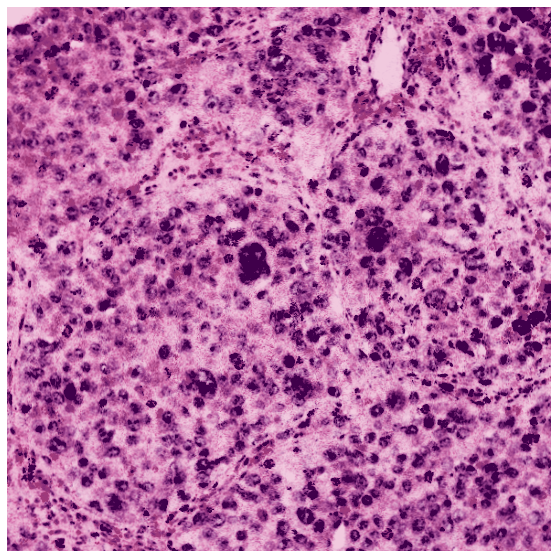

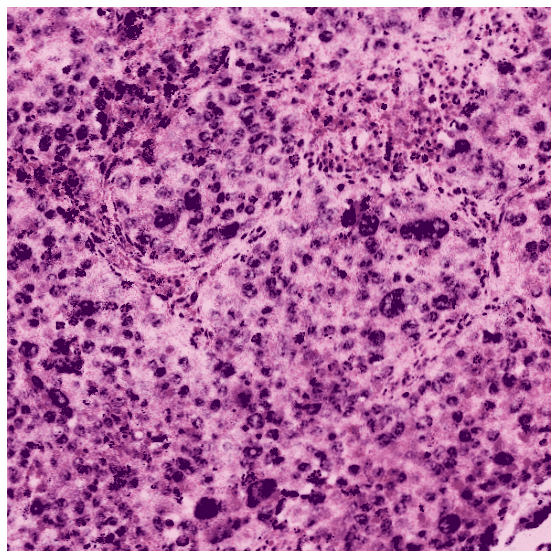

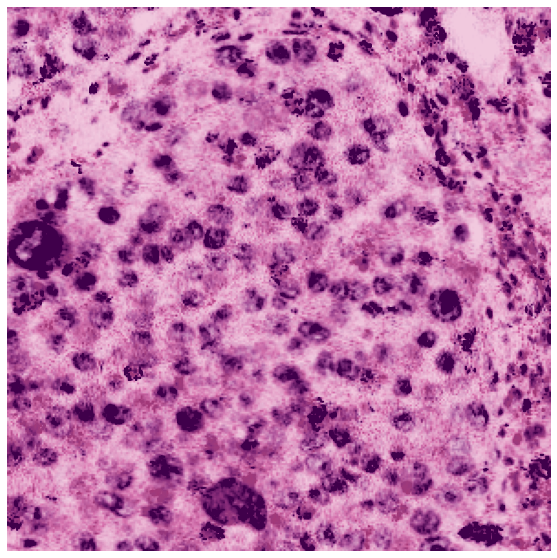

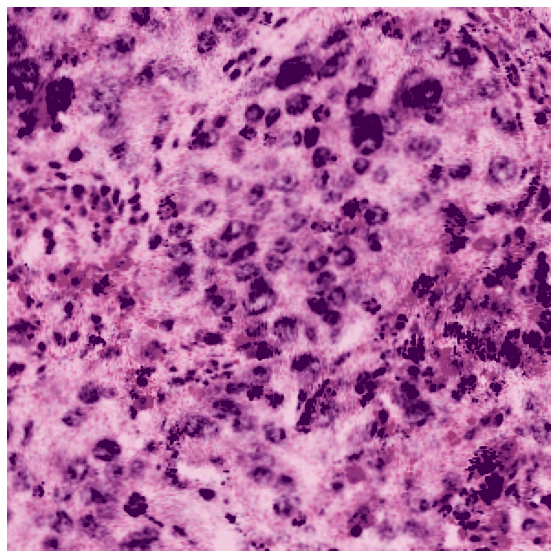

In [126]:
# nuclei_markers = ['Histone3',  'H3K27me3', 'Ki67', 'EZH2', 'DNA1', 'DNA2', 'ICOS1']
# cyto_markers = ['CD3', 'CD27', 'PD1', 'C-Myc', 'CD20','CXCR5','CD4', 'CD21']

nuclei_markers = ['HistoneH3', 'CD68', 'CD8', 'CD20']
cyto_markers = ['COL1', 'CD45RO', 'CD45RA',  'CD31', 'ECadherin', 'PanKeratin', 'SMA', 'Vimentin']


for i, dataset in enumerate(datasets):
    try:
        info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
    except:
        continue
    # imgs_imc, markers = get_imgs(f"{dataset}", "IMC")
    # imgs_imc, markers = get_imgs(f"{core}", "IMC")

    # --- Read IMC images
    func = partial(crop_img, info=info)
    imgs_cropped = joblib_loop(func, imgs_imc)

   
    avg_imgs = []    
    for i, img in enumerate(imgs_cropped):
        if markers[i] in nuclei_markers:
            avg_imgs.append(img)
    img_nuclei = np.array(np.max(avg_imgs, axis=(0)), dtype=np.uint8)

    avg_imgs = []
    for i, img in enumerate(imgs_cropped):
        if markers[i] not in cyto_markers:
            avg_imgs.append(img)
    img_cyto = np.array(np.mean(avg_imgs, axis=(0)), dtype=np.uint8)

    # Stack all cluster representation together 
    data = np.stack((img_nuclei, img_cyto), axis=2)

    # Select colormap 
    cmap1 = plt.cm.PiYG_r
    # Get the colormap colors
    my_cmap1 = cmap1(np.linspace(0.8, 1.0, cmap1.N))
    # Set alpha
    my_cmap1[:,-1] = np.linspace(0.5, 1, cmap1.N)
    # Creat1e new colormap
    my_cmap1 = ListedColormap(my_cmap1)

    # Select colormap 
    cmap2 = plt.cm.PRGn_r
    # Get the colormap colors
    my_cmap2 = cmap2(np.linspace(0.8, 1.0, cmap2.N))
    # Set alpha
    my_cmap2[:,-1] = np.linspace(0, 1, cmap2.N)
    # Creat1e new colormap
    my_cmap2 = ListedColormap(my_cmap2)

    max1 = np.max(img_cyto)
    max2 = np.max(img_nuclei)

    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img_cyto, my_cmap1, vmax=max1//3.5, alpha=0.8)
    ax.imshow(img_nuclei, my_cmap2, vmax=max2//2)
    ax.axis('off')
    fig.savefig(f'{dataset}.png', bbox_inches='tight', dpi=100)
    plt.show()
